In [1]:
from joblib import dump, load
import pandas as pd
from pathlib import Path
import numpy as np
from math import floor, ceil
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from scipy.stats import uniform
from umap import UMAP

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import re
from math import isclose
from decimal import Decimal

from data_prep.sk_pipeline import Cut_last_sample
from data_prep.prepare_recola import add_sequence_index, get_labels, choose_random_sequences, data_generator, plot_cum_explained_var

## Helper Functions

In [2]:
def load_data_one_mod(path_mod: Path, iter_test=False):
    """Load the data of one modality into a df.
    Might lead to memory error for video.

    Inputs:
    path_mod -- path of the folder with data from one modality

    Returns:
    df of one modality with multi-index participant and sample.
    """
    parts = []
    for part in data_generator(path_mod, iter_test):
        parts.append(part[0])
    return pd.concat(parts, axis=0)

In [3]:
def build_df_pca(X_pca: np.array, df: pd.DataFrame, columns: list):
    """Build a new df given old df and pca transformed data.

    Inputs:
    X_pca -- numpy array
    df  -- df, X prior to pca
    label_cols
    """
    df_pca = pd.DataFrame(data=X_pca, index=df.index, columns=columns)
    return df_pca

In [4]:
def load_df_voice_markers(path: Path):
    """ Load txt files with voice region markers into one df.

    Inputs:
    path - string or path like, dir of marker txt files

    Outputs:
    df -- df with markers for voiced regions
    """
    parts_df = []  # list of dfs per participant
    for participant in path.iterdir():  # iterate over .txt files
        # find out the participant name
        reg_match = re.search('(train|dev|test)_[0-9]+', participant.name)
        part_name = reg_match.group(0)
        df = pd.read_csv(participant, sep='\t', header=None)
        # add part as index level
        df['participant'] = part_name
        #df.set_index(['participant', pd.Index(np.arange(df.shape[0]))], inplace=True)
        parts_df.append(df)
    df_markers = pd.concat(parts_df, axis=0)
    return df_markers

In [5]:
def mask_voiced_region(df: pd.DataFrame, markers: pd.DataFrame, sampling_rate):
    """ Indicate for each participant the voiced regions.

    Inputs:
    df -- data of one participant
    markers -- for each participant timestamps of begin/end of voice regions
    sampling-rate -- in Hz

    Output:
    voiced_mask -- Series with shape =(df.shape[0],), where 1 indicates voice and 0 silence

    Assumes X_orig to be sorted by [participant, sample]
    """
    voiced_mask = np.zeros((df.shape[0], ), dtype=bool)
    # get current participant
    part = df.index.get_level_values(level='participant')[0]
    # filter current participant out of markers df
    markers_part = markers.loc[markers['participant'] == part, :]
    # loop over voiced regions for current part
    for i in range(markers_part.shape[0]):
        # be generous in including samples into voiced regions,
        # by using floor for start samples /ceil  for last samples respectively
        start_voice = int(floor(sampling_rate * markers_part.iloc[i, 0]))
        end_voice = int(1 + ceil(sampling_rate * markers_part.iloc[i, 1]))
        voiced_mask[start_voice:end_voice] = 1
    return pd.Series(voiced_mask)

In [6]:
def create_seq_index(df, delta_t, atol=1e-04):
    """Given a df with sample index, create a sequence index."""
    # index has to be sorted
    assert all(df['frametime'].sort_values() == df['frametime'])
    # check whether next sample in df is following immediately in time
    seq_idx = np.zeros((df.shape[0], 1))
    counter = 0  # counts sequences
    for i in range(seq_idx.shape[0] - 1):
        seq_idx[i] = counter
        # if next sample time != current sample_time + delta_t
        # equal does not work well with floats
        if abs(
                Decimal(df.iloc[i]['frametime'] + delta_t) -
                Decimal(df.iloc[i + 1]['frametime'])) > atol:
            counter += 1
    seq_idx[-1] = counter
    df['sequence'] = seq_idx
    return df

In [7]:
def mask_missing(df: pd.DataFrame, masking_val: int, col_matcher: str,
                 mask_col: str):
    """Replace column indicating missing values by masking affected values.
    
    Inputs:
    df - X
    masking_val -- encodes missing values
    col_matcher -- how to identify columns of the current modality
    mask_col -- string identifying the column with the masking info 
    """
    df_masked = df.copy()
    line_mask = (
        df_masked[mask_col] == 0).to_numpy()  # lines with missing values
    # the modality
    col_mask = [
        col_matcher in df_masked.columns[i] for i in range(df_masked.shape[1])
    ]
    df_masked.loc[line_mask, col_mask] = masking_val
    df_masked.drop(mask_col, axis=1, inplace=True)
    return df_masked

In [8]:
def col_filter(df: pd.DataFrame, feature_group: str):
    """Filter multi-level column index by top level."""
    col_mask = [
        df.columns[i][0] == feature_group for i in range(len(X.columns))
    ]
    return df.columns[col_mask]

## Constants

In [9]:
PATH_DATA_AUDIO = Path('AVEC2016', 'features_audio', 'arousal')
PATH_DATA_VIDEO = Path('AVEC2016', 'features_video_appearance', 'arousal')

PATH_LABELS_AROUSAL = Path('AVEC2016', 'ratings_gold_standard',
                           'arousal')
PATH_LABELS_VALENCE = Path('AVEC2016', 'ratings_gold_standard',
                           'valence')
PATH_VOICED_REGIONS = Path('AVEC2016', 'aud_voice_regions')

In [10]:
# where to save X-labelled, X_pool, X_test, ...
PATH_X_LABELLED = Path('AVEC2016', 'x_labelled.csv')
PATH_Y_LABELLED = Path('AVEC2016', 'y_labelled.csv')
PATH_X_POOL = Path('AVEC2016', 'x_pool.csv')
PATH_Y_POOL = Path('AVEC2016', 'y_pool.csv')
PATH_X_TEST = Path('AVEC2016', 'x_test.csv')
PATH_Y_TEST = Path('AVEC2016', 'y_test.csv')

In [11]:
# Participants chosen for test set
PARTS_ALL = [
    '{0}_{1}'.format(i, j) for i in ['train', 'dev']
    for j in ['{0}'.format(k) for k in range(1, 10, 1)]
]
PARTS_TEST = ['dev_1', 'dev_2', 'dev_3', 'dev_5', 'dev_7', 'dev_9']
PARTS_TRAIN = list(set(PARTS_ALL).difference(PARTS_TEST))
# name of labels for sklearn pipeline
Y_COLS = ['y_arousal', 'y_valence']

In [12]:
SAMPLES_PER_PART = 7500
SEQUENCE_LENGTH = 375  # in samples
SAMPLE_RATE = 25  # in Hz
MASKING_VALUE = -99
LABEL_DELAY = 60 # in samples, how much labels are behind X

# Preprocessing Audio

## Load audio features:

In [18]:
X_audio = load_data_one_mod(PATH_DATA_AUDIO)

In [19]:
X_audio.loc['train_1', :]

AVEC16_audio_ws_4_sec_arousal,frametime,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
sample,,,,,,,,,,,,,,,,,,,,,
0.00,0.00,25.20658,0.366261,16.02432,24.39195,35.89069,19.866370,257.1943,295.8320,145.7239,...,-0.030374,-0.006772,0.032986,1.25,1.0,0.3525,0.023848,0.6275,0.410693,-28.57658
0.04,0.04,25.20658,0.366261,16.02432,24.39195,35.89069,19.866370,257.1943,295.8320,145.7239,...,-0.030374,-0.006772,0.032986,1.25,1.0,0.3525,0.023848,0.6275,0.410693,-28.57658
0.08,0.08,25.20658,0.366261,16.02432,24.39195,35.89069,19.866370,257.1943,295.8320,145.7239,...,-0.030374,-0.006772,0.032986,1.25,1.0,0.3525,0.023848,0.6275,0.410693,-28.57658
0.12,0.12,25.20658,0.366261,16.02432,24.39195,35.89069,19.866370,257.1943,295.8320,145.7239,...,-0.030374,-0.006772,0.032986,1.25,1.0,0.3525,0.023848,0.6275,0.410693,-28.57658
0.16,0.16,25.20658,0.366261,16.02432,24.39195,35.89069,19.866370,257.1943,295.8320,145.7239,...,-0.030374,-0.006772,0.032986,1.25,1.0,0.3525,0.023848,0.6275,0.410693,-28.57658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299.84,299.84,22.16749,0.341521,16.62359,19.59822,25.06424,8.440649,263.2463,202.0912,103.4585,...,-0.034749,-0.005328,0.035411,0.75,2.5,0.0940,0.069886,0.3500,0.530236,-42.69846
299.88,299.88,22.16749,0.341521,16.62359,19.59822,25.06424,8.440649,263.2463,202.0912,103.4585,...,-0.034749,-0.005328,0.035411,0.75,2.5,0.0940,0.069886,0.3500,0.530236,-42.69846
299.92,299.92,22.16749,0.341521,16.62359,19.59822,25.06424,8.440649,263.2463,202.0912,103.4585,...,-0.034749,-0.005328,0.035411,0.75,2.5,0.0940,0.069886,0.3500,0.530236,-42.69846


In [20]:
X_audio = X_audio.sort_values(by=['participant', 'sample'])

## Voiced regions

df with markers of voice onset/ offsets per participant: 

In [21]:
df_voice_markers = load_df_voice_markers(PATH_VOICED_REGIONS)

Build mask to indicate unvoiced samples:

In [22]:
voiced_mask = X_audio.groupby('participant').apply(mask_voiced_region,
                                                   markers=df_voice_markers,
                                                   sampling_rate=SAMPLE_RATE)

In [23]:
voiced_mask.shape  # part * sample

(18, 7501)

How many percent are with voice?

In [24]:
voiced_mask.mean(axis=1).mean()

0.4318757499000133

Append mask as column to df:

In [25]:
X_audio['voice_mask'] = voiced_mask.to_numpy().reshape(-1, 1)

In [26]:
X_audio['voice_mask'].head()

participant  sample
dev_1        0.00      False
             0.04      False
             0.08      False
             0.12      False
             0.16      False
Name: voice_mask, dtype: bool

Sanity check: Do original markers df and mask align? 

In [27]:
#df_voice_markers[df_voice_markers['participant'] == 'train_7']

In [28]:
#slicer = pd.IndexSlice
#X_audio.loc[slicer['train_7', 2.16:3.72], 'voice_mask']

## Dimensionality Reduction
### Only keep mean and std dev features (and drop percentiles): 

In [29]:
X_audio_subset = X_audio

In [30]:
X_audio_subset.columns.shape

(90,)

In [31]:
X_audio_subset.head()

AVEC16_audio_ws_4_sec_arousal  frametime  F0semitoneFrom27.5Hz_sma3nz_amean  \
participant sample                                                            
dev_1       0.00                    0.00                            33.6055   
            0.04                    0.04                            33.6055   
            0.08                    0.08                            33.6055   
            0.12                    0.12                            33.6055   
            0.16                    0.16                            33.6055   

AVEC16_audio_ws_4_sec_arousal  F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
participant sample                                                      
dev_1       0.00                                              0.31582   
            0.04                                              0.31582   
            0.08                                              0.31582   
            0.12                                              0.31582   
            0.16                                              0.31582   

AVEC16_audio_ws_4_sec_arousal  F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
participant sample                                                          
dev_1       0.00                                                 22.22658   
            0.04                                                 22.22658   
            0.08                                                 22.22658   
            0.12                                                 22.22658   
            0.16                                                 22.22658   

AVEC16_audio_ws_4_sec_arousal  F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
participant sample                                                          
dev_1       0.00                                                 37.78632   
            0.04                                                 37.78632   
            0.08                                                 37.78632   
            0.12                                                 37.78632   
            0.16                                                 37.78632   

AVEC16_audio_ws_4_sec_arousal  F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
participant sample                                                          
dev_1       0.00                                                 41.06139   
            0.04                                                 41.06139   
            0.08                                                 41.06139   
            0.12                                                 41.06139   
            0.16                                                 41.06139   

AVEC16_audio_ws_4_sec_arousal  F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2  \
participant sample                                                        
dev_1       0.00                                               18.83481   
            0.04                                               18.83481   
            0.08                                               18.83481   
            0.12                                               18.83481   
            0.16                                               18.83481   

AVEC16_audio_ws_4_sec_arousal  F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope  \
participant sample                                                           
dev_1       0.00                                                  185.2374   
            0.04                                                  185.2374   
            0.08                                                  185.2374   
            0.12                                                  185.2374   
            0.16                                                  185.2374   

AVEC16_audio_ws_4_sec_arousal  F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope  \
participant sample                                                             
dev_1       0.00                                                    61.18139   
 

Missing values?

In [32]:
X_audio_subset.isna().mean().mean()

0.0

### Train Test Split:

Choose participants from the original dev set

In [33]:
X_test_audio = X_audio_subset.loc[PARTS_TEST, :].copy()
X_train_audio = X_audio_subset.loc[PARTS_TRAIN, :].copy()

Is proportion of voiced regions similar?

In [34]:
X_test_audio['voice_mask'].mean()

0.3941030084877572

In [35]:
X_train_audio['voice_mask'].mean()

0.4507621206061414

### PCA Training set

PCA - first determine components:

In [36]:
scaler = StandardScaler()
# filter unvoiced regions and drop column voice mask
X_train_z_temp = scaler.fit_transform(X_train_audio.drop('voice_mask', axis=1))

In [37]:
pca_audio_comp = PCA(whiten=True)
pca_audio_comp.fit(X_train_z_temp)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

In [38]:
np.cumsum(pca_audio_comp.explained_variance_ratio_)[44]

0.959414148113472

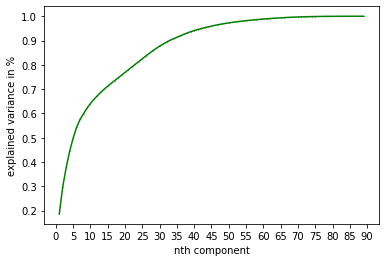

In [39]:
ax = plt.axes()
plot_cum_explained_var(pca_audio_comp, ax)

Conclusion: Keep 45 components

# Preprocessing video

In [40]:
X_video = load_data_one_mod(PATH_DATA_VIDEO)

In [41]:
X_video.drop('frametime', axis=1, inplace=True)
X_video.head()

AVEC16_video_appearance_ws_6_sec_arousal  LGBP_TOP_PCA_1_amean  \
participant sample                                               
dev_8       0.00                                      -0.69256   
            0.04                                      -0.69256   
            0.08                                      -0.69256   
            0.12                                      -0.69256   
            0.16                                      -0.69256   

AVEC16_video_appearance_ws_6_sec_arousal  LGBP_TOP_PCA_2_amean  \
participant sample                                               
dev_8       0.00                                      -0.82834   
            0.04                                      -0.82834   
            0.08                                      -0.82834   
            0.12                                      -0.82834   
            0.16                                      -0.82834   

AVEC16_video_appearance_ws_6_sec_arousal  LGBP_TOP_PCA_3_amean  \
participant sample                                               
dev_8       0.00                                       0.38871   
            0.04                                       0.38871   
            0.08                                       0.38871   
            0.12                                       0.38871   
            0.16                                       0.38871   

AVEC16_video_appearance_ws_6_sec_arousal  LGBP_TOP_PCA_4_amean  \
participant sample                                               
dev_8       0.00                                      -0.26783   
            0.04                                      -0.26783   
            0.08                                      -0.26783   
            0.12                                      -0.26783   
            0.16                                      -0.26783   

AVEC16_video_appearance_ws_6_sec_arousal  LGBP_TOP_PCA_5_amean  \
participant sample                                               
dev_8       0.00                                      -0.24965   
            0.04                                      -0.24965   
            0.08                                      -0.24965   
            0.12                                      -0.24965   
            0.16                                      -0.24965   

AVEC16_video_appearance_ws_6_sec_arousal  LGBP_TOP_PCA_6_amean  \
participant sample                                               
dev_8       0.00                                      -0.10529   
            0.04                                      -0.10529   
            0.08                                      -0.10529   
            0.12                                      -0.10529   
            0.16                                      -0.10529   

AVEC16_video_appearance_ws_6_sec_arousal  LGBP_TOP_PCA_7_amean  \
participant sample                                               
dev_8       0.00                                       -2.7557   
            0.04                                       -2.7557   
            0.08                                       -2.7557   
            0.12                                       -2.7557   
            0.16                                       -2.7557   

AVEC16_video_appearance_ws_6_sec_arousal  LGBP_TOP_PCA_8_amean  \
participant sample                                               
dev_8       0.00                                       0.23448   
            0.04                                       0.23448   
            0.08                                       0.23448   
            0.12                                       0.23448   
            0.16                                       0.23448   

AVEC16_video_appearance_ws_6_sec_arousal  LGBP_TOP_PCA_9_amean  \
participant sample                                               
dev_8       0.00                                      -0.26369   
            0.04                                      -0.26369   
            0.08                

Mark missing values (~ 5 % of video data):

In [42]:
line_mask = X_video.isna().any(axis=1)

In [43]:
X_video['video_mask'] = ~line_mask

In [44]:
line_mask.mean()

0.05374098268379031

In [45]:
X_video.isna().mean()

AVEC16_video_appearance_ws_6_sec_arousal
LGBP_TOP_PCA_1_amean      0.053741
LGBP_TOP_PCA_2_amean      0.053741
LGBP_TOP_PCA_3_amean      0.053741
LGBP_TOP_PCA_4_amean      0.053741
LGBP_TOP_PCA_5_amean      0.053741
                            ...   
LGBP_TOP_PCA_81_stddev    0.053741
LGBP_TOP_PCA_82_stddev    0.053741
LGBP_TOP_PCA_83_stddev    0.053741
LGBP_TOP_PCA_84_stddev    0.053741
video_mask                0.000000
Length: 169, dtype: float64

Samples missing audio and video:

In [46]:
(line_mask & ~X_audio['voice_mask']).mean()

0.03430653690619029

Samples missing video but with audio:

In [47]:
(line_mask & X_audio['voice_mask']).mean()

0.019434445777600024

## Dim Reduction

Explained variance per PC:

In [48]:
pc_var = X_video[X_video.columns.drop(
    list(X_video.filter(regex='stddev|video_mask')))].var(axis=0)

In [49]:
pc_var_perc = pc_var / pc_var.sum() * 100

In [50]:
df_var_pca = pd.concat([pc_var, pc_var_perc], axis=1)
df_var_pca.columns = ['var', 'perc']

Sort by explained % of variance:

In [51]:
df_var_pca.sort_values('perc', axis=0, ascending=False, inplace=True)

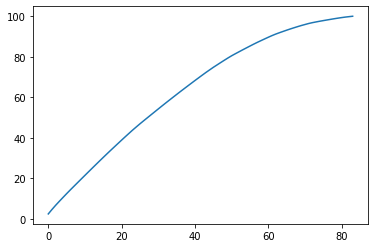

In [52]:
plt.plot(np.cumsum(df_var_pca['perc'].to_numpy()))

One could keep the first 60 dimensions only.

### PCA:
Further reduce dimensionality

In [53]:
X_test_video = X_video.loc[PARTS_TEST, :].copy()
X_train_video = X_video.loc[PARTS_TRAIN, :].copy()

In [54]:
X_train_video.isna().mean()

AVEC16_video_appearance_ws_6_sec_arousal
LGBP_TOP_PCA_1_amean      0.06828
LGBP_TOP_PCA_2_amean      0.06828
LGBP_TOP_PCA_3_amean      0.06828
LGBP_TOP_PCA_4_amean      0.06828
LGBP_TOP_PCA_5_amean      0.06828
                           ...   
LGBP_TOP_PCA_81_stddev    0.06828
LGBP_TOP_PCA_82_stddev    0.06828
LGBP_TOP_PCA_83_stddev    0.06828
LGBP_TOP_PCA_84_stddev    0.06828
video_mask                0.00000
Length: 169, dtype: float64

In [55]:
X_train_vid_clean = X_train_video[X_train_video['video_mask'] == 1].drop(
    'video_mask', axis=1)

In [56]:
scaler_vid = StandardScaler()
X_train_vid_z = scaler_vid.fit_transform(X_train_vid_clean)

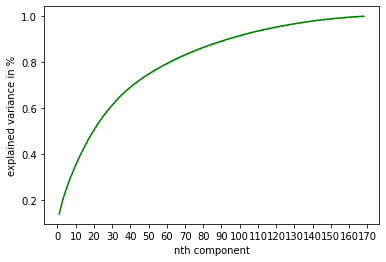

In [57]:
pca_vid = PCA()
pca_vid.fit(X_train_vid_z)
ax = plt.axes()
plot_cum_explained_var(pca_vid, ax)

Keep 120 components of video.

In [58]:
np.cumsum(pca_vid.explained_variance_ratio_)[119]

0.9528721526549482

# Merge modalities and further preprocessing

Build a hierarchical column index for the Column Transformer later on:

In [59]:
top_level_col = ['audio_feat' for i in range(X_audio_subset.shape[1] - 1)]
top_level_col.append('audio_mask')

Running this line twice leads to errors:

In [60]:
X_audio_subset.columns = pd.MultiIndex.from_arrays(
    [top_level_col, X_audio_subset.columns])
#X_audio_subset.rename({"('voice_mask', 'audio_feature')": "('voice_mask', 'audio_mask')"}, axis=1)

In [61]:
top_level_col_vid = ['vid_feat' for i in range(X_video.shape[1] - 1)]
top_level_col_vid.append('vid_mask')

In [62]:
X_video.columns = pd.MultiIndex.from_arrays(
    [top_level_col_vid, X_video.columns])

## Load Labels:

In [63]:
y_arousal = get_labels(PATH_LABELS_AROUSAL)
y_valence = get_labels(PATH_LABELS_VALENCE)

In [64]:
labels = pd.concat([y_arousal, y_valence], axis=1)
labels.columns = pd.MultiIndex.from_product([['labels'], Y_COLS])

In [65]:
labels.sort_values(['participant', 'sample'], axis=0, inplace=True)

Label delay: The labels are systematically delayed, as they were created online.

In [66]:
def shift_labels(df_y: pd.DataFrame, shift_steps: int):
    """Shift labels forward by shift_steps"""
    df = df_y.shift(shift_steps)
    df.fillna(method='backfill', axis=0, inplace=True)
    return df

In [67]:
labels = labels.groupby(['participant']).apply(shift_labels, shift_steps=LABEL_DELAY)

## Merge it all together

In [68]:
X_audio_subset.sort_values(['participant', 'sample'], axis=0, inplace=True)
X_video.sort_values(['participant', 'sample'], axis=0, inplace=True)
labels.sort_values(['participant', 'sample'], axis=0, inplace=True)

In [69]:
X = pd.concat([X_audio_subset, X_video, labels], axis=1)

## Create an additional index-level for the sequence: 

In [70]:
idx_seq = add_sequence_index(X, SEQUENCE_LENGTH)  # create index
X['sequence'] = idx_seq  # add as column

In [71]:
X['sequence'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

Make the sample index count the sample within the sequence (instead of for each participant):

In [72]:
X.reset_index(level='sample', drop=True, inplace=True)  # drop old sample index

In [73]:
def make_sample_index(df):
    """Create sample index counting within a sequence."""
    return pd.Series(np.arange(df.shape[0]))

In [74]:
X['sample'] = X.groupby(['participant', 'sequence'],
                        sort=True).apply(make_sample_index).to_numpy()

In [75]:
X.set_index(['sequence', 'sample'], append=True, inplace=True)

## Remove the last sample per participant:
All participants have exactly 7501 samples. Drop 1 sample per participant, for easier splitting into sequences.

In [76]:
samples_per_participant = X.loc['train_3'].shape[0]
sample_cutter = Cut_last_sample(samples_per_participant)

In [77]:
X = sample_cutter.transform(X)

In [78]:
X.loc[('dev_1', 0)]

audio_feat                                    \
AVEC16_audio_ws_4_sec_arousal  frametime F0semitoneFrom27.5Hz_sma3nz_amean   
sample                                                                       
0                                   0.00                          33.60550   
1                                   0.04                          33.60550   
2                                   0.08                          33.60550   
3                                   0.12                          33.60550   
4                                   0.16                          33.60550   
...                                  ...                               ...   
370                                14.80                          22.65390   
371                                14.84                          22.42852   
372                                14.88                          22.16625   
373                                14.92                          21.94616   
374                                14.96                          22.02929   

                                                                      \
AVEC16_audio_ws_4_sec_arousal F0semitoneFrom27.5Hz_sma3nz_stddevNorm   
sample                                                                 
0                                                           0.315820   
1                                                           0.315820   
2                                                           0.315820   
3                                                           0.315820   
4                                                           0.315820   
...                                                              ...   
370                                                         0.493223   
371                                                         0.495513   
372                                                         0.496924   
373                                                         0.499553   
374                                                         0.503464   

                                                                          \
AVEC16_audio_ws_4_sec_arousal F0semitoneFrom27.5Hz_sma3nz_percentile20.0   
sample                                                                     
0                                                               22.22658   
1                                                               22.22658   
2                                                               22.22658   
3                                                               22.22658   
4                                                               22.22658   
...                                                                  ...   
370                                                             13.91081   
371                                                             13.88805   
372                                                             13.87928   
373                                                             13.84912   
374                                                             13.84912   

                                                                          \
AVEC16_audio_ws_4_sec_arousal F0semitoneFrom27.5Hz_sma3nz_percentile50.0   
sample                                                                     
0                                                               37.78632   
1                                                               37.78632   
2                                                               37.78632   
3                                                               37.78632   
4                                                               37.78632   
...                                                                  ...   
370                                                             17.06153   
371                                                             16.92867   
372                        

# Pipeline

Apply all the preprocessing steps determined earlier in a sklearn pipeline

Treat each modality accordingly, labels pass through:

In [79]:
audio_pipeline = Pipeline([('std_scaler', StandardScaler()),
                           ('imputer',
                            SimpleImputer(missing_values=np.nan,
                                          strategy='mean')),
                           ('pca', PCA(n_components=60, whiten=True))])
video_pipeline = Pipeline([('std_scaler', StandardScaler()),
                           ('imputer',
                            SimpleImputer(missing_values=np.nan,
                                          strategy='mean')),
                           ('pca', PCA(n_components=120, whiten=True))])

In [80]:
full_pipeline = ColumnTransformer(
    [('audio', audio_pipeline, col_filter(X, 'audio_feat')),
     ('video', video_pipeline, col_filter(X, 'vid_feat'))],
    remainder='passthrough')

Pass X_train through pipeline and build df again in the end:

In [81]:
X_train = X.loc[PARTS_TRAIN, :]
X_test = X.loc[PARTS_TEST, :]

In [82]:
X_test.shape

(45000, 261)

In [83]:
X_train_pca = full_pipeline.fit_transform(X_train)

In [84]:
columns_pca = ['audio_comp{0}'.format(i + 1) for i in range(60)] + [
    'video_comp{0}'.format(i + 1) for i in range(120)
] + ['aud_mask', 'vid_mask', 'y_arousal', 'y_valence']

Add column and index again:

In [85]:
X_train_pca = build_df_pca(X_train_pca, X_train, columns_pca)

Pass X_test through pipeline and build df again in the end:

In [86]:
help(build_df_pca)

Help on function build_df_pca in module __main__:

build_df_pca(X_pca: <built-in function array>, df: pandas.core.frame.DataFrame, columns: list)
    Build a new df given old df and pca transformed data.
    
    Inputs:
    X_pca -- numpy array
    df  -- df, X prior to pca
    label_cols



In [87]:
X_test_pca = full_pipeline.transform(X_test)
X_test_pca = build_df_pca(X_test_pca, X_test, columns_pca)

In [88]:
X_test_pca

audio_comp1 audio_comp2 audio_comp3 audio_comp4  \
participant sequence sample                                                   
dev_1       0        0         -1.38962     1.80826     1.98457    0.854336   
                     1         -1.38962     1.80826     1.98458    0.854336   
                     2         -1.38962     1.80826     1.98458    0.854335   
                     3         -1.38962     1.80826     1.98458    0.854334   
                     4         -1.38962     1.80826     1.98458    0.854333   
...                                 ...         ...         ...         ...   
dev_9       19       370       0.312203    0.886468   -0.205217    0.263554   
                     371       0.312203    0.886468   -0.205215    0.263553   
                     372       0.312203    0.886467   -0.205212    0.263552   
                     373       0.312204    0.886467   -0.205209    0.263552   
                     374       0.312204    0.886466   -0.205207    0.263551   

                            audio_comp5 audio_comp6 audio_comp7 audio_comp8  \
participant sequence sample                                                   
dev_1       0        0         0.388772   0.0418413   -0.409197  -0.0802496   
                     1         0.388775   0.0418386   -0.409203  -0.0802475   
                     2         0.388779   0.0418358    -0.40921  -0.0802455   
                     3         0.388783   0.0418331   -0.409216  -0.0802434   
                     4         0.388786   0.0418304   -0.409223  -0.0802413   
...                                 ...         ...         ...         ...   
dev_9       19       370       -1.39017     2.47991    -2.06112   -0.738015   
                     371       -1.39017     2.47991    -2.06112   -0.738013   
                     372       -1.39017      2.4799    -2.06113   -0.738011   
                     373       -1.39016      2.4799    -2.06114   -0.738009   
                     374       -1.39016      2.4799    -2.06114   -0.738007   

                            audio_comp9 audio_comp10  ... video_comp115  \
participant sequence sample                           ...                 
dev_1       0        0          0.25076      3.21159  ...      0.596566   
                     1          0.25076      3.21157  ...      0.596566   
                     2         0.250759      3.21156  ...      0.596566   
                     3         0.250759      3.21154  ...      0.596566   
                     4         0.250759      3.21152  ...      0.596566   
...                                 ...          ...  ...           ...   
dev_9       19       370       0.972197     0.332041  ...      0.286274   
                     371       0.972197     0.332023  ...      0.286274   
                     372       0.972196     0.332006  ...      0.286274   
                     373       0.972196     0.331989  ...      0.286274   
                     374       0.972195     0.331972  ...      0.286274   

                            video_comp116 video_comp117 video_comp118  \
participant sequence sample                                             
dev_1       0        0          -0.924018      0.901248      -1.68111   
                     1          -0.924018      0.901248      -1.68111   
                     2          -0.924018      0.901248      -1.68111   
                     3          -0.924018      0.901248      -1.68111   
                     4          -0.924018      0.901248      -1.68111   
...                                   ...           ...           ...   
dev_9       19       370          6.78191       1.26349      -4.16483   
                     371          6.78191       1.26349      -4.16483   
                     372          6.78191       1.26349      -4.16483   
                     373          6.78191       1.26349      -4.16483   
                     374          6.78191       1.26349      -4.16483   

                            video_comp119 vide

## Save Test Set


Save mask as float type, not boolean for tf later on:

In [89]:
X_test_pca = X_test_pca.astype(np.float)

Split up in y and X again:

In [90]:
Y_test = X_test_pca[Y_COLS].copy()
X_test_pca.drop(Y_COLS, axis=1, inplace=True)

Save test set:
Comment out for saving to disk:

In [91]:
#X_test_pca.to_csv(PATH_X_TEST)
#Y_test.to_csv(PATH_Y_TEST)

# X pool

X_test processing is done for now. Below: <br>Divide X_train in X_pool and X_labelled at t=0:

## Init X_labelled
Randomly choose small proportion of sequences from X_train.

In [92]:
idx_seq = X_train_pca.unstack().index
idx_len = len(idx_seq) 

In [93]:
rng = np.random.default_rng(seed=41)
idx_i_chosen = rng.choice(idx_len, 16, replace=False)

In [94]:
idx_chosen = idx_seq[idx_i_chosen]

In [95]:
X_labelled = X_train_pca.unstack().loc[idx_chosen].stack()

In [96]:
X_pool = X_train_pca.unstack().drop(idx_chosen).stack()

In [102]:
X_labelled

audio_comp1  audio_comp2  audio_comp3  \
participant sequence sample                                          
dev_8       1        0         -0.053890    -0.677845     0.416363   
                     1         -0.050871    -0.692879     0.383727   
                     2         -0.053819    -0.689590     0.368770   
                     3          0.011716    -0.675414     0.241338   
                     4          0.012184    -0.681335     0.192098   
...                                  ...          ...          ...   
train_8     15       370        0.868382    -0.204126    -1.216187   
                     371        0.876343    -0.237853    -1.236016   
                     372        0.875152    -0.241427    -1.238838   
                     373        0.868055    -0.239390    -1.247782   
                     374        0.857283    -0.238285    -1.218814   

                             audio_comp4  audio_comp5  audio_comp6  \
participant sequence sample                                          
dev_8       1        0         -1.058032     0.508120    -1.648184   
                     1         -1.042342     0.480631    -1.655907   
                     2         -1.035318     0.428764    -1.664408   
                     3         -1.027328     0.392530    -1.692612   
                     4         -1.005924     0.412269    -1.688793   
...                                  ...          ...          ...   
train_8     15       370       -0.457242     0.132704    -0.128806   
                     371       -0.417635     0.140470    -0.106545   
                     372       -0.405117     0.147989    -0.115100   
                     373       -0.408326     0.151972    -0.128778   
                     374       -0.399343     0.175896    -0.192367   

                             audio_comp7  audio_comp8  audio_comp9  \
participant sequence sample                                          
dev_8       1        0         -0.940815     0.698242     0.510756   
                     1         -1.026391     0.844345     0.562309   
                     2         -1.057854     0.860627     0.536737   
                     3         -1.068109     0.973937     0.434012   
                     4         -1.103297     0.992951     0.342476   
...                                  ...          ...          ...   
train_8     15       370       -1.515133    -0.301354    -0.258248   
                     371       -1.517259    -0.171301    -0.223657   
                     372       -1.522282    -0.149225    -0.219155   
                     373       -1.515748    -0.166359    -0.225259   
                     374       -1.485678    -0.277070    -0.281335   

                             audio_comp10  ...  video_comp113  video_comp114  \
participant sequence sample                ...                                 
dev_8       1        0           0.142484  ...      -1.631331       0.721529   
                     1           0.149704  ...      -1.675591       0.752993   
                     2           0.143866  ...      -1.750332       0.797049   
                     3           0.311572  ...      -1.825122       0.825782   
                     4           0.248052  ...      -1.875960       0.834167   
...                                   ...  ...            ...            ...   
train_8     15       370         0.051343  ...       0.688971       0.161224   
                     371         0.082979  ...       0.721282       0.164245   
                     372         0.087371  ...       0.752643       0.153609   
                     373         0.087676  ...       0.784182       0.137633   
                     374         0.117664  ...       0.810205       0.118850   

                             video_comp115  video_comp116  video_comp117  \
participant sequence sample                                                
dev_8       1        0           -0.707015      -1.042572      -0.784818   
                     1     

Finalize dfs for data and labels:

In [98]:
X_labelled = X_labelled.astype(np.float)
X_pool = X_pool.astype(np.float)

In [99]:
Y_labelled = X_labelled[Y_COLS].copy()
Y_pool = X_pool[Y_COLS].copy()

X_labelled.drop(Y_COLS, axis=1, inplace=True)
X_pool.drop(Y_COLS, axis=1, inplace=True)

## Save to disk:

Comment out for saving to disk:

In [100]:
#X_labelled.to_csv(PATH_X_LABELLED)
#Y_labelled.to_csv(PATH_Y_LABELLED)
#X_pool.to_csv(PATH_X_POOL)
#Y_pool.to_csv(PATH_Y_POOL)

## Look at distribution of labels in X_labelled:

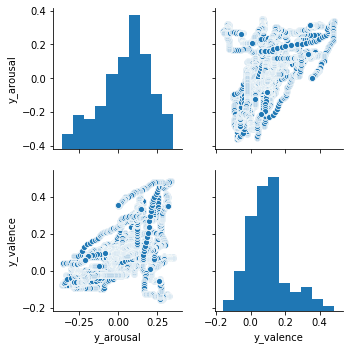

In [101]:
sns.pairplot(Y_labelled)